# Description


This notebook will look at the cyclones on the slope and cyclones on the shelf. Comparisons will be drawn with the data from the GLOBEC3 cruise of Lee & Brink (2010). Questions to be answered:

1. What is the vertical structure of the cyclone?
2. How much of the cyclone is shelf water / eddy water / slope water? What is the depth dependence of these dyes?
3. Is vortex stretching responsible for the generation of anticyclonic / cyclonic vorticity?

# Generic functions

In [1]:
# test pymatbridge
#from pymatbridge import Matlab
#mlab = Matlab()
#mlab.start()

Starting MATLAB on http://localhost:44462
 visit http://localhost:44462/exit.m to shut down same
...MATLAB started and connected!


True

In [3]:
%matplotlib inline
%load_ext secnum
%secnum

import numpy as np
import h5py
import netCDF4 

import numexpr as ne
from scipy.io import loadmat

from datetime import datetime
import time
from IPython import display
import pylab

import pyroms

# matplotlib section
import matplotlib as mpl
import matplotlib.pyplot as plt
# big figures
mpl.rcParams['savefig.dpi'] = 2 * mpl.rcParams['savefig.dpi']
# better color cycling
import brewer2mpl
colors =  brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors
mpl.rcParams['axes.color_cycle'] = colors
#mpl.rcParams['lines.linewidth'] = 1.5
# need wider colorbar
# change default colormap
# change default fonts

# zoomable inline plots
#mport mpld3
#mpld3.disable_notebook()

# test for estimating baroclinicity
def baroclinicity(u, z):
    u = np.ma.masked_array(u, np.isnan(u))
    umean = u.mean()
    #urms = np.sqrt((u**2).mean())
    #uarms = np.sqrt( ((u-umean)**2).mean() )
    
    # integrate kinetic energy
    ketot = np.abs( 0.5 * np.trapz(u**2, x=z.transpose()))
    if np.ma.is_masked(u):
        length = len(u.compressed())
    else:
        length = len(u)

    # fill in with ones to make depth averaged velocity
    keda  = np.abs(0.5 * np.trapz((umean**2) * u/u, x=z.transpose()))
    
    bc = (ketot-keda)/ketot
    #bc = uarms/umean
    if np.ma.is_masked(u):
        #print( 'Total KE = {0:.2f} | DA KE = {1:0.2f}'.format(ketot[0], keda[0]) )
        return bc[0]
    else:
        #print( 'Total KE = {0:.2f} | DA KE = {1:0.2f}'.format(ketot, keda) )
        return bc
    
# define the data reading function
def read_data(hisfile, vorfile, rgrid, ix, iy, it, favg):
    
    csdname = 'dye_01'; eddname = 'dye_03'; zdname = 'dye_02';
    csdye = hisfile[csdname][it,:,iy,ix]
    eddye = hisfile[eddname][it,:,iy,ix]
    zdye  = hisfile[zdname][it,:,iy,ix]
    
    u = hisfile['u'][it,:,iy,ix]
    v = hisfile['v'][it,:,iy,ix]
    
    csini = hisfile[csdname][1,:,iy,ix]
    edini = hisfile[eddname][1,:,iy,ix]
    zini  = hisfile[zdname][1,:,iy,ix]
    
    rvprof = vorfile['rv'][it,:,iy-1,ix-1]
    rvprofnorm = rvprof/favg[iy,ix]
    
    rvornorm = vorfile['rv'][it,-1,:,:]/favg
    zvor = vorfile['z_pv'][:,iy-1,ix-1]
    
    dcsd = csdye - xsb;
    dzd  = zdye - zini;
    ded  = eddye - edini;
    
    zr = rgrid.vgrid.z_r[:,:,:]
    zvec = zr[:,iy,ix]
    
    return (rvornorm, rvprofnorm, dcsd, dzd, ded, zvor, zvec, u, v)
    
# define the plotting function
def plot_profiles(rvornorm, isb, ix, iy, zvec, zvor, dcsd, dzd, ded, rvprofnorm, u, v):
    
    plt.subplot(4,2,(1,2))
    plt.pcolor(rvornorm, cmap='RdBu_r')
    plt.axhline(isb, color='w')
    plt.autoscale(True,tight=True)
    plt.colorbar()
    plt.plot(ix-1,iy-1,'b*',hold=True)
    plt.xlim(100,160)
    plt.ylim(0,100)
    plt.title('rvor/f')
    
    plt.subplot(4,2,3)
    plt.plot(dcsd/1000,zvec)
    plt.axvline(0, color='k')
    plt.axhline(-hsb, color='k')
    plt.ylabel('Z (m)')
    plt.xlabel('CS dye - ysb')
    
    plt.subplot(4,2,4)
    plt.plot(dzd,zvec)
    plt.axhline(-hsb, color='k')
    plt.ylabel('Z (m)')
    plt.xlabel('Z-dye')
    
    plt.subplot(4,2,5)
    plt.plot(ded,zvec)
    plt.axhline(-hsb, color='k')
    plt.ylabel('Z (m)')
    plt.xlabel('Eddy-dye')
    
    plt.subplot(4,2,6)
    plt.plot(rvprofnorm,zvor)
    plt.axhline(-hsb, color='k')
    plt.axvline(0, color='k')
    plt.ylabel('Z (m)')
    plt.xlabel('Rel vor / f')
    plt.xlim(-1,1)
    
    plt.subplot(4,2,7)
    plt.plot(u, zvec)
    plt.xlabel('u (m/s) - BC = {0:.2f}'.format(baroclinicity(u, zvec)))
    
    plt.subplot(4,2,8)
    plt.plot(v, zvec)
    plt.xlabel('v (m/s) - BC = {0:.2f}'.format(baroclinicity(v, zvec)))
    plt.tight_layout()
    

scrip.so not found. Remapping function will not be available


ImportError: No module named brewer2mpl

# Cyclone on shelf

In [14]:
dirname = 'runs/topoeddy/runew-07-visc4/'
fname = dirname + 'ocean_his.extract.nc'
vorname = dirname + 'ocean_vor.nc'

isb = 26; xsb = 36750; hsb = 80;

# load file
hisfile = h5py.File(fname,'r')
vorfile = h5py.File(vorname,'r')

# get ROMS grid
rgrid = pyroms.grid.get_ROMS_grid('id',hist_file=fname,grid_file=fname)

# get f
f     = hisfile['f']
favg = (f[0:-1,:] + f[1:,:])/2
favg = (favg[:,0:-1] + favg[:,1:])/2


Load cartesian grid from file


### Cyclone at time of formation
Plot vertical profiles of dyes and relative vorticity. Plots are at approximately the center of the vortex. Horizontal lines indicate shelfbreak depth.

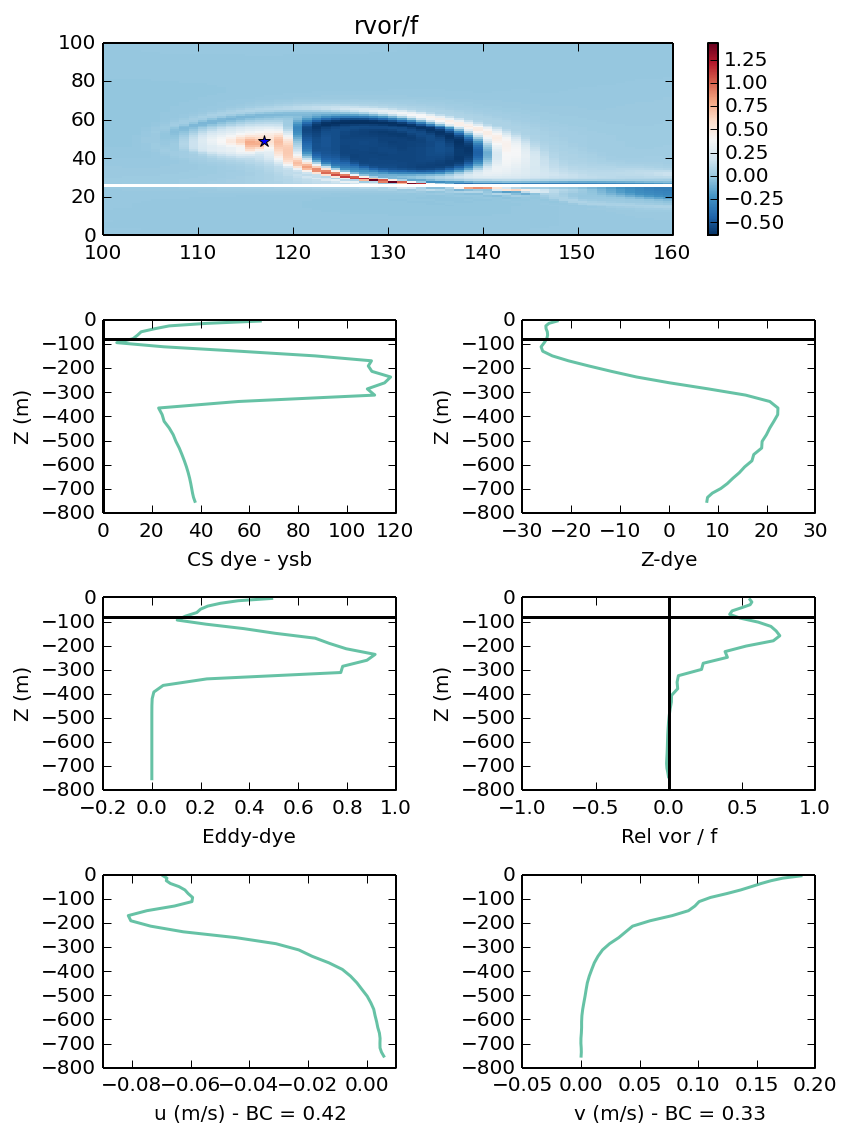

In [774]:
#%matplotlib inline
pylab.rcParams['figure.figsize'] = (6.0, 8.0)
ix=118; iy = 50; it = 94-1
(rvornorm, rvprofnorm, dcsd, dzd, ded, zvor, zvec, u, v) = read_data(hisfile, vorfile, rgrid, ix, iy, it, favg)
plot_profiles(rvornorm, isb, ix, iy, zvec, zvor, dcsd, dzd, ded, rvprofnorm, u, v)

Observations:

1. Vertical scale of cyclone is 500m = vertical scale of eddy _initially_ but what is the current vertical scale?
2. There is a peak in cyclonic vorticity at around shelfbreak depth.
3. Water in the cyclone above shelfbreak depth is sourced from the shelf, below that is eddy water mostly and then slope water.
4. Slightly non-zero eddy dye value above shelfbreak depth is probably mixing.
5. The cyclone has a subsurface eddy water signature that moves with it. I'm looking at a combined shelf-eddy water feature that has cyclonic vorticity throughout its depth.


Now, where in the shelf is the shelf water coming from?

In [50]:
csmin = abs(dcsd.min()/1000)
rrshelf = 5 # km
print 'min water is from', csmin, 'km = ', csmin/5, ' (shelfbreak) Rossby radii inshore of shelfbreak'

#mpld3.disable_notebook()
#plt.plot(dcsd)

min water is from 9.2023671875 km =  1.8404734375  (shelfbreak) Rossby radii inshore of shelfbreak


### Cyclone when downstream 
Let's make the same plots as in earlier figure at a later point in time when the cyclone has separated.

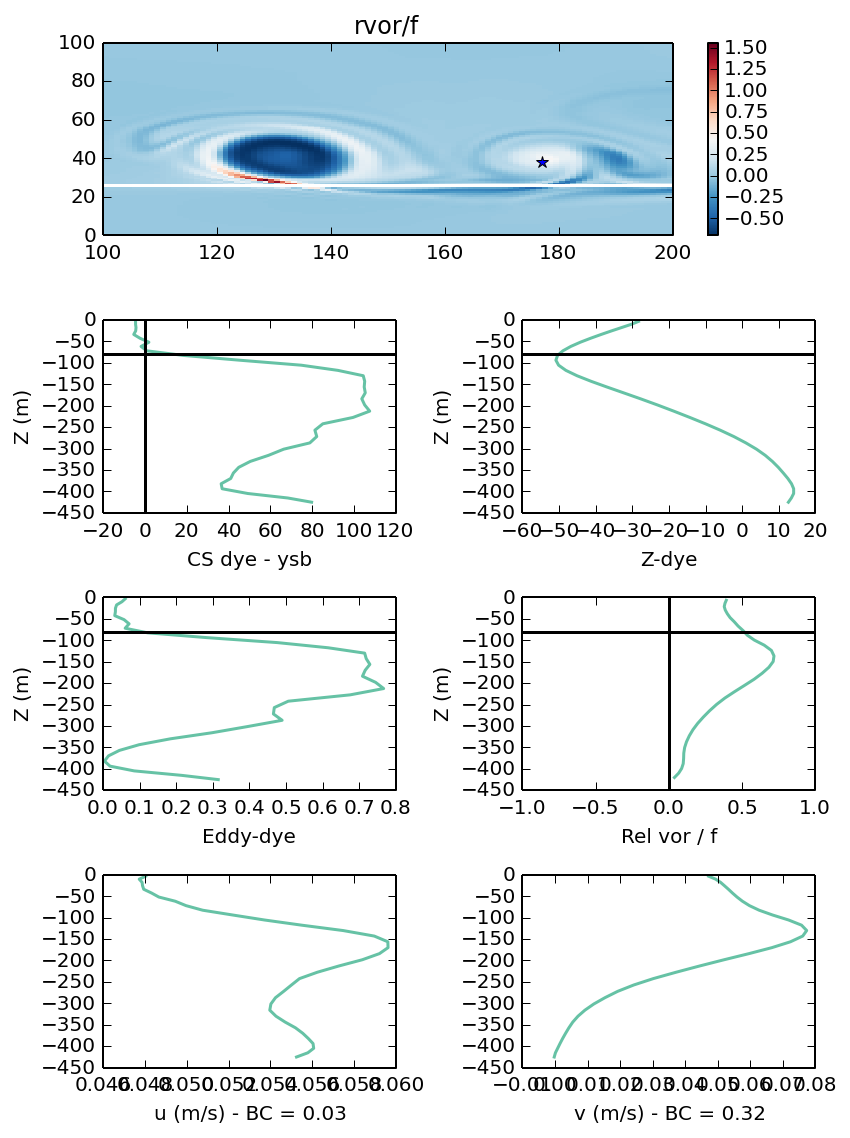

In [775]:
pylab.rcParams['figure.figsize'] = (6.0, 8.0)

# new location for cyclone when it is downstream
ixnew = 178; iynew = 40-1; itnew = 126-1;

# read, plot and change axis limits
(rvornorm, rvprofnorm, dcsd, dzd, ded, zvor, zvec, u, v) = read_data(hisfile, vorfile, rgrid, ixnew, iynew, itnew, favg)
plot_profiles(rvornorm, isb, ixnew, iynew, zvec, zvor, dcsd, dzd, ded, rvprofnorm, u, v) 
plt.subplot(4,2,(1,2))
plt.xlim(100,200); plt.ylim(0,100);

Observations:

1. CS dye has homogenized in upper 100 m. Mixing?
2. Cyclone seems to occupy entire water column - has it chosen an isobath _equal_ to it's vertical scale?
3. Higher eddy dye value near surface - increased mixing in of waters as time progresses.
4. Sub-shelfbreak depth peak in relative vorticity persists.
5. Sub-surface eddy water signature also _persists_!

# Anticyclone on shelf


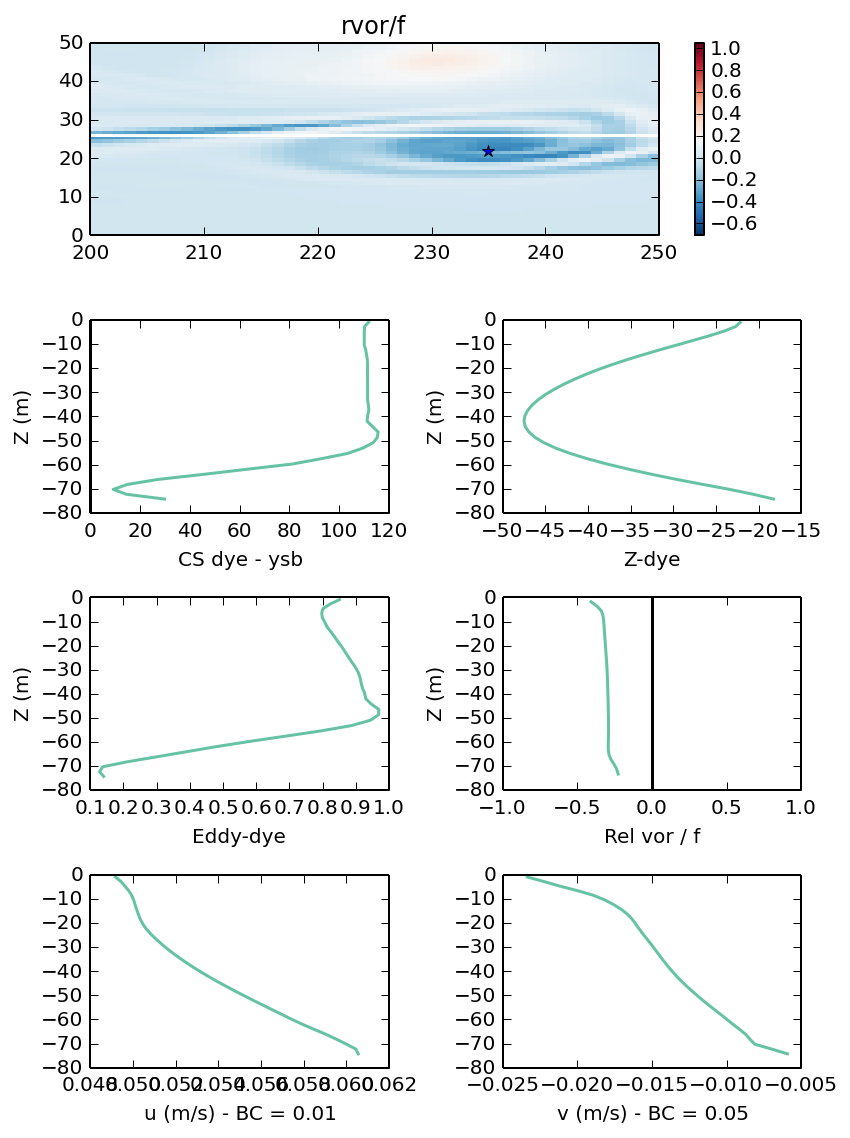

In [781]:
ixac = 236; iyac = 23; itac = 118; # accounts for python indexing

pylab.rcParams['figure.figsize'] = (6.0, 8.0)

# read, plot and change axis limits
(rvornorm, rvprofnorm, dcsd, dzd, ded, zvor, zvec, u, v) = read_data(hisfile, vorfile, rgrid, ixac, iyac, itac, favg)
plot_profiles(rvornorm, isb, ixac, iyac, zvec, zvor, dcsd, dzd, ded, rvprofnorm, u, v) 
plt.subplot(4,2,(1,2))
plt.xlim(200,250); plt.ylim(0,50); 

Observations:

1. Relative vorticity structure is *different*. This one is barotropic.
2. Definitely *all* non-shelf water in cyclone. Mostly eddy and some slope water on shelf - indicated by eddy dye and cross-shelf dye.

Now to check how barotropic the velocities are